In [1]:
import os
import time
import librosa
import numpy as np
import tensorflow as tf
import cPickle as pickle
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
pickle_file = "../../my_features/US8K_logmel128_patchslice.pickle"
with open(pickle_file, "rb") as f:
    dataset = pickle.load(f)
    X_train_all = dataset["X_train"]/10
    Y_train_all = dataset["Y_train"]
    X_valid_all = dataset["X_valid"]/10
    Y_valid_all = dataset["Y_valid"]
    X_test1_all = dataset["X_test1"]/10
    Y_test1_all = dataset["Y_test1"]
    X_test2_all = dataset["X_test2"]/10
    Y_test2_all = dataset["Y_test2"]
    del dataset
# X_train = X_train_all[(np.argmax(Y_train_all, axis=1) == 4)+(np.argmax(Y_train_all, axis=1) == 3)]
# Y_train = Y_train_all[(np.argmax(Y_train_all, axis=1) == 4)+(np.argmax(Y_train_all, axis=1) == 3)][:,(4,3)]

# X_valid = X_valid_all[(np.argmax(Y_valid_all, axis=1) == 4)+(np.argmax(Y_valid_all, axis=1) == 3)]
# Y_valid = Y_valid_all[(np.argmax(Y_valid_all, axis=1) == 4)+(np.argmax(Y_valid_all, axis=1) == 3)][:,(4,3)]

# X_test1 = X_test1_all[(np.argmax(Y_test1_all, axis=1) == 4)+(np.argmax(Y_test1_all, axis=1) == 3)]
# Y_test1 = Y_test1_all[(np.argmax(Y_test1_all, axis=1) == 4)+(np.argmax(Y_test1_all, axis=1) == 3)][:,(4,3)]

# X_test2 = X_test2_all[(np.argmax(Y_test2_all, axis=1) == 4)+(np.argmax(Y_test2_all, axis=1) == 3)]
# Y_test2 = Y_test2_all[(np.argmax(Y_test2_all, axis=1) == 4)+(np.argmax(Y_test2_all, axis=1) == 3)][:,(4,3)]

X_train = X_train_all
Y_train = Y_train_all

X_valid = X_valid_all
Y_valid = Y_valid_all

X_test1 = X_test1_all
Y_test1 = Y_test1_all

X_test2 = X_test2_all
Y_test2 = Y_test2_all


In [3]:
print np.sum(Y_train_all, axis = 0)
print np.sum(Y_train_all)
print np.unique(np.argmax(Y_train_all, axis=1), return_counts=True)
print ('training data: ' , X_train_all.shape, Y_train_all.shape)

print (np.sum(Y_train_all, axis=0))

[ 2793.   765.  2763.  2027.  2321.  2704.   213.  2625.  2717.  2800.]
21728.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([2793,  765, 2763, 2027, 2321, 2704,  213, 2625, 2717, 2800]))
('training data: ', (21728, 16384), (21728, 10))
[ 2793.   765.  2763.  2027.  2321.  2704.   213.  2625.  2717.  2800.]


In [4]:
IMG_SIZE = 128
IMG_FLAT_SIZE = IMG_SIZE*IMG_SIZE
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
N_LABELS = Y_train.shape[1]
N_CONV_LAYER = 3
N_FC_LAYER = 2

In [5]:
N_LABELS

10

## 2. CNN

In [6]:
## Helper function

## Weight initialization
def new_weights(shape, stddev):
    initial = tf.truncated_normal(shape=shape, stddev=stddev,dtype=tf.float32)
    return tf.Variable(initial)
## Biases initialization
def new_biases(length):
    initial = tf.constant(value=1, shape=[length], dtype=tf.float32)
    return tf.Variable(initial)

def get_layer_shape(in_layer):
    shape = in_layer.get_shape()
#     n_features = shape[1:4].num_elements()
    return np.array([shape[1:2].num_elements(), shape[2:3].num_elements(), shape[3:4].num_elements()])

## Fully connected layer
def new_layer(in_layer, n_in_features, n_out_features, relu=True):
    stddev = np.sqrt(np.float(2)/(n_in_features + n_out_features))
    weights = new_weights([n_in_features, n_out_features], 0.1)
    biases = new_biases(n_out_features)
    out_layer = tf.matmul(in_layer, weights) + biases
    if relu:
        out_layer = tf.nn.relu(out_layer)
    return out_layer, weights    

#Helper function creates conv layer
def new_conv_layer(in_layer, filter_size, in_channels, n_filter, pooling=True):
    
    in_layer_shape = get_layer_shape(in_layer)
    in_features = np.prod(in_layer_shape[0:2])
    if(pooling):
        out_features = (in_layer_shape[0] - filter_size + 1)*(in_layer_shape[1] - filter_size + 1)/4
                                    
    else:
        out_features = (in_layer_shape[0] - filter_size + 1)*(in_layer_shape[1] - filter_size + 1)
        
#     print in_features, out_features
    stddev = np.sqrt(np.float(2)/(in_features+out_features))
    weights = new_weights([filter_size, filter_size, in_channels, n_filter], 0.1)
    biases = new_biases(n_filter)
    out_layer = tf.nn.conv2d(in_layer, weights, strides=[1,1,1,1], padding='VALID')
    out_layer += biases
    if pooling:
        out_layer = tf.nn.max_pool(out_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    out_layer = tf.nn.relu(out_layer)
    return out_layer, weights
def flatten_layer(in_layer):
    shape = in_layer.get_shape()
    n_features = shape[1:4].num_elements()
    layer_flat = tf.reshape(in_layer, [-1, n_features])
    return layer_flat, n_features

    

In [7]:
X_cnn = tf.placeholder(tf.float32, [None, IMG_FLAT_SIZE])
X_cnn_train = tf.reshape(X_cnn, [-1, IMG_SIZE, IMG_SIZE, 1])
Y = tf.placeholder(tf.float32, [None, N_LABELS])
print X_cnn
print X_cnn_train

Tensor("Placeholder:0", shape=(?, 16384), dtype=float32)
Tensor("Reshape:0", shape=(?, 128, 128, 1), dtype=float32)


In [8]:
## Conv layer 1
filter_size_1 = 5
n_filter_1 = 16
conv_layer_1, weight_conv_1 = new_conv_layer(X_cnn_train, filter_size_1, 1, n_filter_1)
print (conv_layer_1)

Tensor("Relu:0", shape=(?, 62, 62, 16), dtype=float32)


In [9]:
## Conv layer 2
filter_size_2 = 5
n_filter_2 = 36
conv_layer_2, weight_conv_2 = new_conv_layer(conv_layer_1, filter_size_2, n_filter_1, n_filter_2)
print (conv_layer_2)

Tensor("Relu_1:0", shape=(?, 29, 29, 36), dtype=float32)


In [10]:
## Flatten layer
layer_flat, n_features = flatten_layer(conv_layer_2)
print (layer_flat, n_features)

(<tf.Tensor 'Reshape_1:0' shape=(?, 30276) dtype=float32>, 30276)


In [11]:
## Fully-connected layer
fc_size = 128
layer_fc1, weights_fc_1 = new_layer(layer_flat, n_in_features=n_features, n_out_features=fc_size)
print (layer_fc1)

Tensor("Relu_2:0", shape=(?, 128), dtype=float32)


In [12]:
layer_fc2, weights_fc_2 = new_layer(layer_fc1, n_in_features=fc_size, n_out_features=N_LABELS, relu=False)
print (layer_fc2)

Tensor("add_3:0", shape=(?, 10), dtype=float32)


In [13]:
keep_prob = tf.placeholder(tf.float32)
layer_fc2_drop = tf.nn.dropout(layer_fc2, keep_prob=keep_prob)
print (layer_fc2_drop)

Tensor("dropout/mul:0", shape=(?, 10), dtype=float32)


In [14]:
y_nn_softmax = tf.nn.softmax(layer_fc2)
print y_nn_softmax

Tensor("Softmax:0", shape=(?, 10), dtype=float32)


In [15]:
#slice data for testing model
X_train = X_train[:2000]
Y_train = Y_train[:2000]

print (X_train.shape)
print (Y_train.shape)
print (np.unique(np.argmax(Y_train, axis=1), return_counts=True))

(2000, 16384)
(2000, 10)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([253,  61, 230, 205, 216, 257,  18, 251, 270, 239]))


In [16]:
LEARNING_RATE = 1e-3

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=Y)
# cost = tf.reduce_mean(cross_entropy)
cost = tf.reduce_mean(cross_entropy )
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
minimize_cost = optimizer.minimize(cost)
grads = optimizer.compute_gradients(cost,[weights_fc_1, weights_fc_2])

y_true = tf.argmax(Y, dimension=1)
y_pred = tf.argmax(y_nn_softmax, dimension=1)

In [17]:
#slice data for testing model
X_train = X_train_all[:1000,:,]
Y_train = Y_train_all[:1000,:]
print (Y_train.shape)
print (np.unique(np.argmax(Y_train, axis=1), return_counts=True))

(1000, 10)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([122,  25, 127, 116, 107, 123,  10, 119, 133, 118]))


In [18]:
classID = {
    0: "AirCon",
    1: "Car horn",
    2: "Children playing",
    3: "Dog bark",
    4: "Drilling",
    5: "Engine idling",
    6: "Gun shot",
    7: "Jackhammer",
    8: "Siren",
    9: "Street music"
}

BATCH_SIZE = 50
TRAINING_EPOCHS = 10

## Helper function for optimization
def optimize(train_x, train_y, n_epochs, batch_size, session, saver):
        n_samples = train_x.shape[0]
        sample_IDs = np.arange(n_samples)
        n_iterations = np.int(np.floor(n_samples/batch_size))+1
        start_time = time.time()
        cost_history = np.empty(shape=[1],dtype=float)
        print "Training......."
        print "-- Elapsed time -- Epoch -- Cost value -- fc_1 median abs -- fc_2 median abs --"

        for epoch in np.arange(n_epochs+1):
            np.random.shuffle(sample_IDs)
            train_x_p, train_y_p = train_x[sample_IDs], train_y[sample_IDs]
            for itr in np.arange(n_iterations):
                start = (itr * batch_size) % (n_samples - batch_size)
                batch_x, batch_y = train_x_p[start:start + batch_size], train_y_p[start:start + batch_size]
                feed_dict_train = {X_cnn: batch_x, Y: batch_y, keep_prob: 1}
                _, c = session.run([minimize_cost, cost], feed_dict=feed_dict_train)
                g = session.run([grad for grad, _ in grads], feed_dict=feed_dict_train)
                
                
            if(epoch % (n_epochs/10) == 0):
                print "-- {:12.6f} -- {:5d} -- {:10.5f} -- {:15.11f} -- {:15.11f} --".format((time.time() - start_time), 
                                                                                    epoch, 
                                                                                    c, 
                                                                                    np.median(np.absolute(g[0])), 
                                                                                    np.median(np.absolute(g[1])))
            cost_history = np.append(cost_history,c)
        saver.save(sess, 'cnn_model/cnn_test')
        saver.export_meta_graph('cnn_model/cnn_test')
        print ("---Running time: %s seconds ---" % (time.time() - start_time))
        print ('*'*50)
        fig = plt.figure(figsize=(10,5))
        plt.plot(cost_history)
        plt.axis([0,epoch,0,np.max(cost_history)])
        plt.show()

def output_log_file(train, valid, test1, test2):
    file_name = pickle_file.split('/')[-1].split('.')[0]
    with open("log/logfile.txt", "ab") as text_file:
        text_file.write('='*60)
        text_file.write('\n')
        text_file.write("Time: {0}\n".format(datetime.now()))
        text_file.write("Data: " + file_name +"\n")    
        
        
#         text_file.write("Number of input samples: {:6d}\n".format(N_SA)
        text_file.write("Number of input features: {:5d}\n".format(IMG_FLAT_SIZE))
#         text_file.write("Number of input labels: {:5d}\n".format(N_LABELS)
        text_file.write("Number of convolutional layer: {0}\n".format(N_CONV_LAYER))
        text_file.write("\tFilter size:\t")
        for idx in np.arange(1, N_CONV_LAYER + 1):
            text_file.write('{0}\t'.format(filter_size[idx]))
        text_file.write("\n")
        text_file.write("\tNumber of filter:\t")
        for idx in np.arange(1, N_CONV_LAYER + 1):
            text_file.write('{0}\t'.format(n_filter[idx]))
        text_file.write("\n")
        text_file.write("Number of fully-connected layer: {0}\n".format(N_FC_LAYER))
        text_file.write("Hidden units: {:3d}  - {:3d}\n".format(fc_size, N_LABELS))
        text_file.write("Training epochs: {:5d}\n".format(TRAINING_EPOCHS))
        text_file.write("Batch size: {:3d}\n".format(BATCH_SIZE))
                        
        text_file.write('\tTrain\tValid\tTest1\tYoutube\n')
        text_file.write("Fscore\t {:1.2f} \t {:1.2f} \t {:1.2f} \t {:1.2f} \n".format(train[0], 
                                                                                      valid[0], 
                                                                                      test1[0], 
                                                                                      test2[0]))
        text_file.write("Acc\t {:1.2f} \t {:1.2f} \t {:1.2f} \t {:1.2f} \n".format(train[1], 
                                                                                   valid[1], 
                                                                                   test1[1], 
                                                                                   test2[1]))
        
        

## Helper function to print confusion matrix
def make_prediction(test_x, test_y, session, batch_size):
    print "Making prediction......."
    start_time = time.time()
    n_samples = test_x.shape[0]
    sample_IDs = np.arange(n_samples)
    n_iterations = np.int(np.floor(n_samples/batch_size))+1
    pred = np.zeros(n_samples)
    true = np.zeros(n_samples)
    for itr in np.arange(n_iterations):
        start = (itr * batch_size) % (n_samples - batch_size)
        batch_x, batch_y = test_x[start:start + batch_size], test_y[start:start + batch_size]
        feed_dict_test = {X_cnn: batch_x, Y: batch_y, keep_prob: 1}
        pred[start:start + batch_size], true[start:start + batch_size] = session.run([y_pred, y_true], feed_dict=feed_dict_test)

## Performance Evaluation metrics
    ## Accuracy
    accuracy = accuracy_score(true, pred)
    print ("Accuracy: {:3.2f}".format(accuracy))
    ## F-score
    p,r,f,s = precision_recall_fscore_support(true, pred, average='macro')
    print ("F-Score: {:3.2f}".format(f))
    
    ## Confusion matrix
    print ("Confusion Matrix")
    print confusion_matrix(true, pred)
#     print ("Analyzing result")
#     for ID, name in classID.items():
#         x = pred[(true == ID)*(pred != ID)]  
#         unique_class, unique_count = np.unique(x, return_counts=True)
#         print ('-'*50)
#         print " Class {0} is mistaken with: ".format(name)
#         for c, y in zip(unique_class, unique_count):        
#             print "# {0}: {1} samples".format(classID[c], y)
#     print ('-'*50)
    print ("---Running time: {0} seconds ---".format((time.time() - start_time)))
    print ('*'*50)
    return accuracy, f
                    

Training.......
-- Elapsed time -- Epoch -- Cost value -- fc_1 median abs -- fc_2 median abs --
--    14.779266 --     0 --    2.54910 --   0.00000000000 --   0.02000802755 --
--    29.882798 --     1 --    1.78526 --   0.00000000000 --   0.00444572512 --
--    44.546897 --     2 --    1.68461 --   0.00000000000 --   0.00894323736 --
--    59.464534 --     3 --    1.45818 --   0.00000000000 --   0.00988958590 --
--    74.560656 --     4 --    1.00153 --   0.00000000000 --   0.01086236443 --
--    89.982624 --     5 --    0.99730 --   0.00000000000 --   0.01104400866 --
--   105.887008 --     6 --    0.81503 --   0.00000000000 --   0.00914625078 --
--   121.325569 --     7 --    0.88206 --   0.00000000000 --   0.01232656650 --
--   136.215060 --     8 --    0.44622 --   0.00000000000 --   0.00788471289 --
--   151.140283 --     9 --    0.61393 --   0.00000000000 --   0.01342446636 --
--   165.903759 --    10 --    0.29074 --   0.00000000000 --   0.00671682693 --
---Running time: 166.606

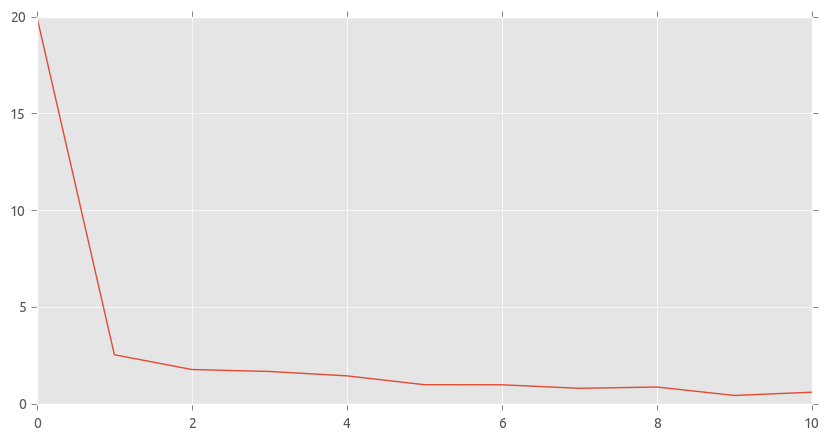

Making prediction on validation set
Making prediction.......
Accuracy: 0.41
F-Score: 0.36
Confusion Matrix
[[541   1   9 146   0  51   0   0  79  20]
 [ 27  10   8   5   5   4   0   6   1  12]
 [184   0 236  71   4  68   0   1 100 120]
 [ 52   0  56 371  15  33   4   0  14  45]
 [177  17   6  86 242  63   0  72  21  46]
 [284  12 111  57   5 262   0   1  99   6]
 [ 34   0   1  15   1   2  16   0   0  23]
 [435   0   1   5   7  22   0  35   3  16]
 [ 96   0  42  23   3  92   0   0 302  19]
 [215   1  84  74  16  16   1   4  16 364]]
---Running time: 18.9654769897 seconds ---
**************************************************
Making training prediction on test 1 set
Making prediction.......
Accuracy: 0.52
F-Score: 0.48
Confusion Matrix
[[403   0   3   1   1  14   0  11   5   3]
 [ 17  21   4   8   2   1   0   1  11   7]
 [ 22   0 104  72   0  46   0   0  52  92]
 [ 24   0  25 184   9  11   0   4  15  13]
 [120   0  14  31  88  28   0   6  35  26]
 [ 63   0  23  53   0 210   0   0   2   7

/home/kyle/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [19]:


with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    optimize(X_train, Y_train, TRAINING_EPOCHS, BATCH_SIZE, sess, saver)
    
#     print ("Making prediction on training set")
#     train = make_prediction(X_train, Y_train, sess)
    print ("Making prediction on validation set")
    valid = make_prediction(X_valid, Y_valid, sess, BATCH_SIZE)
    print ("Making training prediction on test 1 set")
    test1 = make_prediction(X_test1, Y_test1, sess, BATCH_SIZE)
    print ("Making training prediction on test 2 set")
    test2 = make_prediction(X_test2, Y_test2, sess, BATCH_SIZE)
    

    
    
    

In [18]:
X_test2.shape

(671, 16384)

In [22]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, 'cnn_model/cnn_test')
    test2 = make_prediction(X_test1, Y_test1, sess, BATCH_SIZE)
    

Making prediction.......
Accuracy: 0.54
F-Score: 0.56
Confusion Matrix
[[226   0 127   3   4  13   0   2   6  60]
 [  0  56  10   1   0   0   0   0   0   5]
 [  3   0 327  22   1   1   1   0   5  28]
 [  3   0  60 193   1   2   0   0   6  20]
 [  8   3  30  10 210   4   2   2  50  29]
 [ 75   0 197   1   0  60   0   4   2  19]
 [  1   0   2  11   1   0  16   0   0   0]
 [ 98   0   2   0  74   5   0 137   0   6]
 [ 27   3  75  55   9   1   1   0 114  23]
 [ 22   4  71  15   3   1   0   3  19 254]]
---Running time: 9.09455180168 seconds ---
**************************************************


In [37]:
np.random.seed(2017)
x = np.arange(10)
a = np.arange(10)

In [38]:

np.random.shuffle(x)
print (x)

[1 3 7 4 8 0 2 5 6 9]


In [39]:


np.random.shuffle(a)
print (a)

[5 0 9 2 7 1 3 4 6 8]
